# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
print(f"Running batch inference for: {today}")

Running batch inference for: 2025-11-13 16:54:34.011179


## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
sensors = location['sensors']  # 多传感器

print(f"City: {city}")
print(f"Sensors: {len(sensors)}")
for s in sensors:
    print(f"  - {s['street']}")

2025-11-13 16:55:01,947 INFO: Initializing external client
2025-11-13 16:55:01,948 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-13 16:55:02,931 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-13 16:55:03,878 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1298583
City: tampere
Sensors: 5
  - tampere
  - kaleva
  - pirkankatu
  - epila-2
  - linja-autoasema


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
# ========== 加载模型 ==========
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_multisensor",  # 你的模型名
    version=1,
)

fv = retrieved_model.get_feature_view()
print(f"Feature View: {fv.name}")

# 下载模型
saved_model_dir = retrieved_model.download()
print(f"Model downloaded to: {saved_model_dir}")

2025-11-13 16:55:59,444 INFO: Initializing for batch retrieval of feature vectors
Feature View: air_quality_fv_multisensor


Downloading: 0.000%|          | 0/90 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/263931 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/333174 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/100876 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/108364 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/101419 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111028 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/101653 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/21863 elapsed<00:00 remaining<?

Model downloaded to: C:\Users\Fujitsu\AppData\Local\Temp\a1ac38a0-2d3b-40e6-843f-84c5d8349708\air_quality_xgboost_model_multisensor/1


In [7]:
# ========== 加载Pipeline（关键）==========
import os,joblib

# 检查是否有pipeline文件
if os.path.exists(saved_model_dir + "/model_pipeline.pkl"):
    # 加载完整pipeline
    model_pipeline = joblib.load(saved_model_dir + "/model_pipeline.pkl")
    print("Loaded model pipeline (with preprocessing)")
else:
    # 降级：只加载XGBoost模型（需要手动预处理）
    model_pipeline = XGBRegressor()
    model_pipeline.load_model(saved_model_dir + "/model.json")
    print("Loaded XGBoost model only (manual preprocessing needed)")

# 加载street映射（如果有）
if os.path.exists(saved_model_dir + "/street_mapping.json"):
    with open(saved_model_dir + "/street_mapping.json", "r") as f:
        street_mapping = json.load(f)
    print(f"Loaded street mapping: {street_mapping}")

print("\nModel loaded successfully!")
model_pipeline

Loaded model pipeline (with preprocessing)
Loaded street mapping: {'0': 'kaleva', '1': 'epila-2', '2': 'tampere', '3': 'linja-autoasema', '4': 'pirkankatu'}

Model loaded successfully!


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['street'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False,...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
# ========== Part 2: 获取未来天气数据 ==========
weather_fg = fs.get_feature_group(
    name='weather_sensors',
    version=1,
)

# 获取未来7天天气
batch_weather = weather_fg.filter(weather_fg.date >= today).read()
print(f"Weather forecast: {len(batch_weather)} days")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 
Weather forecast: 6 days


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
# ========== 循环为每个传感器生成预测==========
import numpy as np

all_predictions = []

for sensor in sensors:
    street_name = sensor['street']
    print(f"\n{'='*50}")
    print(f"Processing sensor: {street_name}")
    print(f"{'='*50}")
    
    # 准备该传感器的数据
    sensor_batch = batch_weather.copy()
    sensor_batch['street'] = street_name
    
    # ========== 添加lag features ==========
    air_quality_fg = fs.get_feature_group(name='air_quality_sensors', version=1)
    historical_df = air_quality_fg.read()
    sensor_history = historical_df[
        (historical_df['city'] == city) & 
        (historical_df['street'] == street_name)
    ].sort_values('date').tail(3)
    
    if len(sensor_history) >= 3:
        recent_pm25 = sensor_history['pm25'].values[-3:]
    else:
        print(f"  ⚠️  Not enough history, using default values")
        recent_pm25 = np.array([10.0, 10.0, 10.0])
    
    # 递归预测
    predictions = []
    
    for idx, row in sensor_batch.iterrows():
        # 构建特征DataFrame（匹配训练时的列名）
        pred_row = pd.DataFrame({
            'pm25_lag_1': [recent_pm25[-1]],
            'pm25_lag_2': [recent_pm25[-2]],
            'pm25_lag_3': [recent_pm25[-3]],
            'street': [street_name],
            # 添加weather_sensors_前缀
            'weather_sensors_temperature_2m_mean': [row['temperature_2m_mean']],
            'weather_sensors_precipitation_sum': [row['precipitation_sum']],
            'weather_sensors_wind_speed_10m_max': [row['wind_speed_10m_max']],
            'weather_sensors_wind_direction_10m_dominant': [row['wind_direction_10m_dominant']],
        })
        
        # 预测
        pred = model_pipeline.predict(pred_row)[0]
        predictions.append(pred)
        
        # 更新lag
        recent_pm25 = np.append(recent_pm25[1:], pred)
    
    sensor_batch = sensor_batch.sort_values(by=['date'])
    sensor_batch['predicted_pm25'] = predictions
    sensor_batch['days_before_forecast_day'] = range(1, len(sensor_batch)+1)
    sensor_batch['city'] = city
    sensor_batch['country'] = country
    
    all_predictions.append(sensor_batch)
    print(f"Generated {len(predictions)} predictions for {street_name}")

# 合并所有传感器预测
batch_data_all = pd.concat(all_predictions, ignore_index=True)
batch_data_all = batch_data_all.sort_values(by=['street', 'date'])

print(f"\nTotal predictions: {len(batch_data_all)} (across {len(sensors)} sensors)")
batch_data_all.head(10)


Processing sensor: tampere
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.42s) 
2025-11-13 17:10:13,104 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-13 17:10:13,105 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-13 17:10:13,109 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-13 17:10:13,110 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-13 17:10:13,114 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-13 17:10:13,115 WARNING: Dep

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,predicted_pm25,days_before_forecast_day,country
18,2025-11-14 00:00:00+00:00,1.80,0.1,12.522619,288.435028,tampere,epila-2,27.660738,1,Finland
19,2025-11-15 00:00:00+00:00,1.10,0.0,15.542662,256.607483,tampere,epila-2,33.375313,2,Finland
20,2025-11-16 00:00:00+00:00,2.65,0.2,12.879752,243.435013,tampere,epila-2,28.556023,3,Finland
21,2025-11-17 00:00:00+00:00,0.20,0.0,4.213692,250.016800,tampere,epila-2,24.208977,4,Finland
22,2025-11-18 00:00:00+00:00,-3.40,0.0,14.205182,351.253906,tampere,epila-2,25.402004,5,Finland
23,2025-11-19 00:00:00+00:00,-3.85,0.0,5.771239,86.423744,tampere,epila-2,28.160772,6,Finland
6,2025-11-14 00:00:00+00:00,1.80,0.1,12.522619,288.435028,tampere,kaleva,14.916647,1,Finland
7,2025-11-15 00:00:00+00:00,1.10,0.0,15.542662,256.607483,tampere,kaleva,21.247135,2,Finland
8,2025-11-16 00:00:00+00:00,2.65,0.2,12.879752,243.435013,tampere,kaleva,21.846663,3,Finland
9,2025-11-17 00:00:00+00:00,0.20,0.0,4.213692,250.016800,tampere,kaleva,20.932154,4,Finland


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-13 17:11:49,017 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



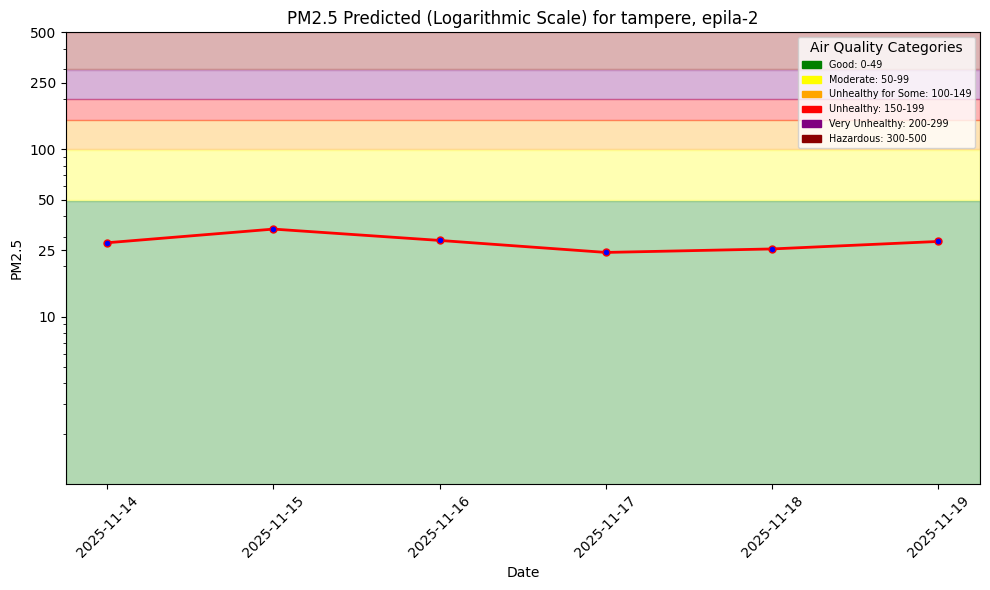

✅ Saved forecast: d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_forecast_epila-2.png


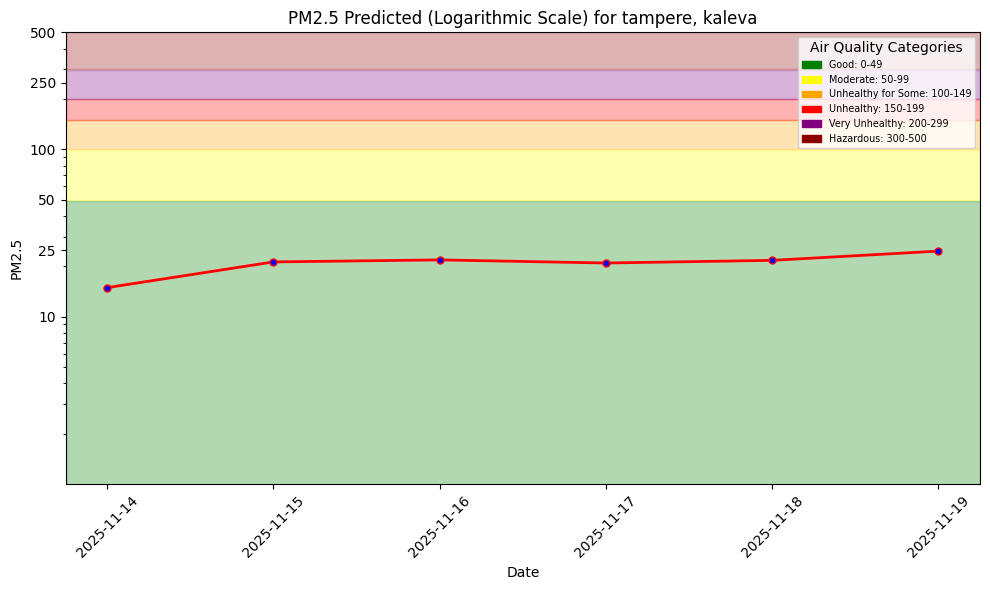

✅ Saved forecast: d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_forecast_kaleva.png


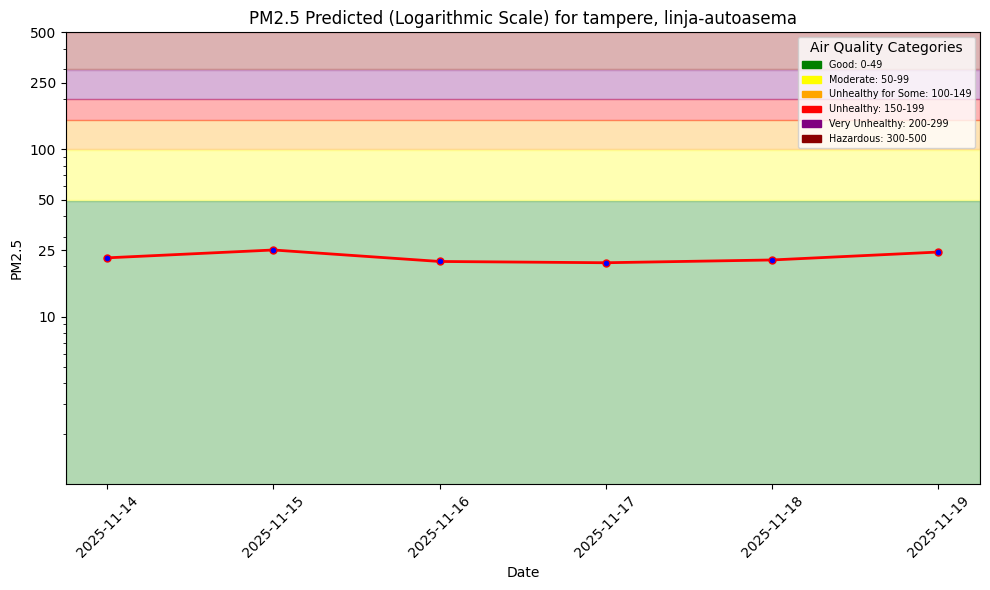

✅ Saved forecast: d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_forecast_linja-autoasema.png


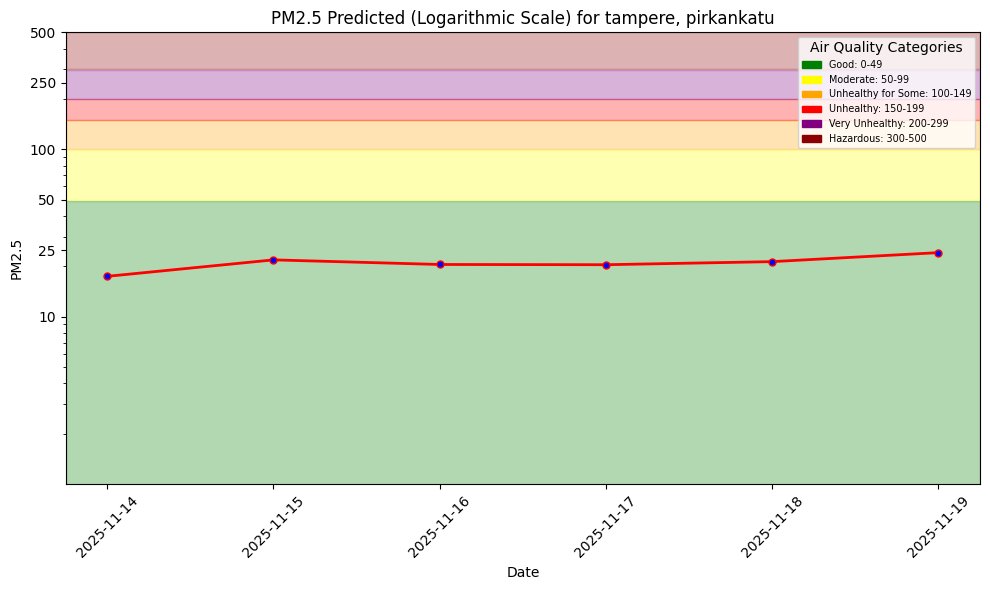

✅ Saved forecast: d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_forecast_pirkankatu.png


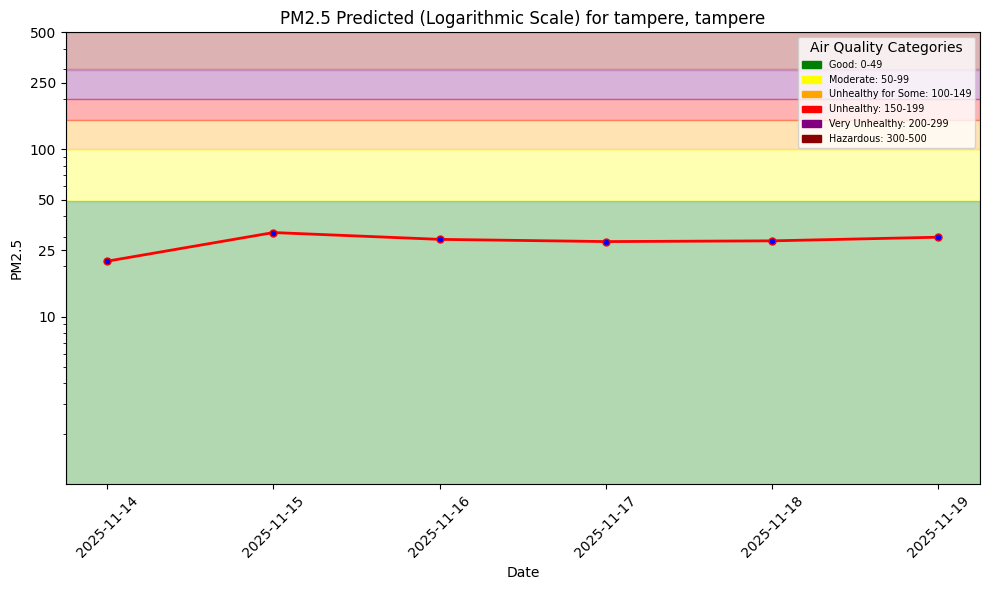

✅ Saved forecast: d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_forecast_tampere.png


In [14]:
# ========== Part 3a: 生成预测图 ==========
import os
pred_dir = f"{root_dir}/docs/air-quality/assets/img"
os.makedirs(pred_dir, exist_ok=True)

for street_name in batch_data_all['street'].unique():
    sensor_preds = batch_data_all[batch_data_all['street'] == street_name]
    
    pred_file_path = f"{pred_dir}/pm25_forecast_{street_name}.png"
    plt_obj = util.plot_air_quality_forecast(
        city, street_name, sensor_preds, pred_file_path, hindcast=False
    )
    plt_obj.show()
    print(f"✅ Saved forecast: {pred_file_path}")

In [15]:
# ========== Part 3b: 插入Monitoring FG ==========
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_multisensor',
    description='Multi-sensor air quality prediction monitoring',
    version=1,
    primary_key=['city', 'street', 'date', 'days_before_forecast_day'],
    event_time="date"
)

# 只保留需要的列
cols_to_insert = ['city', 'street', 'date', 'country', 
                  'predicted_pm25', 'days_before_forecast_day']
batch_data_insert = batch_data_all[cols_to_insert]

monitor_fg.insert(batch_data_insert, write_options={"wait_for_job": False})
print("Predictions inserted to monitoring FG")

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1298583/fs/1286215/fg/1711463


Uploading Dataframe: 100.00% |██████████| Rows 30/30 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_multisensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298583/jobs/named/aq_predictions_multisensor_1_offline_fg_materialization/executions
Predictions inserted to monitoring FG


In [16]:
# ========== Part 3c: 生成Hindcast图 ==========
print("\n" + "="*50)
print("Generating Hindcast Charts")
print("="*50)

# 只取提前1天的预测
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

for street_name in sensors:
    street_val = street_name['street']
    
    # 筛选该传感器
    sensor_monitoring = monitoring_df[monitoring_df['street'] == street_val]
    sensor_actual = air_quality_fg.read()
    sensor_actual = sensor_actual[
        (sensor_actual['street'] == street_val) & 
        (sensor_actual['city'] == city)
    ]
    
    # 合并预测和实际
    preds = sensor_monitoring[['date', 'predicted_pm25']]
    outcomes = sensor_actual[['date', 'pm25']]
    
    hindcast_df = pd.merge(preds, outcomes, on='date', how='inner')
    hindcast_df = hindcast_df.sort_values('date')
    
    if len(hindcast_df) > 0:
        hindcast_file = f"{pred_dir}/pm25_hindcast_{street_val}.png"
        plt_obj = util.plot_air_quality_forecast(
            city, street_val, hindcast_df, hindcast_file, hindcast=True
        )
        plt_obj.show()
        print(f"Saved hindcast for {street_val}: {len(hindcast_df)} days")
    else:
        print(f"No hindcast data yet for {street_val}")

print("\n🎉 Batch Inference Completed!")
print(f"Generated {len(sensors)} forecast charts")
print(f"Generated hindcast charts for available data")


Generating Hindcast Charts
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.19s) 
No hindcast data yet for tampere
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.18s) 
No hindcast data yet for kaleva
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.75s) 
No hindcast data yet for pirkankatu
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 
No hindcast data yet for epila-2
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.38s) 
No hindcast data yet for linja-autoasema

🎉 Batch Inference Completed!
Generated 5 forecast charts
Generated hindcast charts for available data


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [17]:
# ========== 上传所有图片到Hopsworks ==========
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")

# 创建目录（如果不存在）
base_path = f"Resources/airquality/{city}_multisensor_{str_today}"
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

print(f"\n{'='*50}")
print("Uploading images to Hopsworks")
print(f"{'='*50}")

# 循环上传每个传感器的图片
for sensor in sensors:
    street_name = sensor['street']
    
    # Forecast图
    forecast_file = f"{pred_dir}/pm25_forecast_{street_name}.png"
    if os.path.exists(forecast_file):
        dataset_api.upload(
            forecast_file, 
            base_path, 
            overwrite=True
        )
        print(f"Uploaded forecast: {street_name}")
    
    # Hindcast图
    hindcast_file = f"{pred_dir}/pm25_hindcast_{street_name}.png"
    if os.path.exists(hindcast_file):
        dataset_api.upload(
            hindcast_file, 
            base_path, 
            overwrite=True
        )
        print(f"Uploaded hindcast: {street_name}")

# 获取Hopsworks URL
proj_url = project.get_url()
images_url = f"{proj_url}/settings/fb/path/Resources/airquality"

print(f"\n{'='*50}")
print("🎉 BATCH INFERENCE COMPLETED!")
print(f"{'='*50}")
print(f"\nSummary:")
print(f"  - Processed {len(sensors)} sensors in {city}")
print(f"  - Generated {len(sensors)} forecast charts")
print(f"  - Generated hindcast charts (where data available)")
print(f"\nView images in Hopsworks:")
print(f"   {images_url}")
print(f"\nLocal images saved to:")
print(f"   {pred_dir}")


Uploading images to Hopsworks


Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_fo…

Uploaded forecast: tampere


Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_fo…

Uploaded forecast: kaleva


Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_fo…

Uploaded forecast: pirkankatu


Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_fo…

Uploaded forecast: epila-2


Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img/pm25_fo…

Uploaded forecast: linja-autoasema

🎉 BATCH INFERENCE COMPLETED!

Summary:
  - Processed 5 sensors in tampere
  - Generated 5 forecast charts
  - Generated hindcast charts (where data available)

View images in Hopsworks:
   https://c.app.hopsworks.ai:443/p/1298583/settings/fb/path/Resources/airquality

Local images saved to:
   d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book/docs/air-quality/assets/img


---